Firstly, I make a dataframe from one instance of gpx data from a run to start building the code that will map this geo-spatially. 

In [112]:
import xml.etree.ElementTree as ET
import pandas as pd
from geopy.distance import geodesic

# Define GPX file path
gpx_file_path = "skye_strava_data/activities/12111055853.gpx"

# Parse the GPX XML file
tree = ET.parse(gpx_file_path)
root = tree.getroot()

# GPX uses a namespace, so we need to define it
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Extract track points
track_data = []
for trkpt in root.findall(".//default:trkpt", ns):
    lat = float(trkpt.get("lat"))
    lon = float(trkpt.get("lon"))
    ele = float(trkpt.find("default:ele", ns).text)
    time = trkpt.find("default:time", ns).text
    track_data.append((lat, lon, ele, time))

# Convert to DataFrame
df = pd.DataFrame(track_data, columns=["Latitude", "Longitude", "Elevation", "Time"])

# Convert time column to datetime format
df["Time"] = pd.to_datetime(df["Time"])

# Display the first few rows
df.head()


,Latitude,Longitude,Elevation,Time
0,51.595759,-0.376236,63.6,2024-08-10 12:38:15+00:00
1,51.595746,-0.376215,63.6,2024-08-10 12:38:16+00:00
2,51.595732,-0.376193,63.6,2024-08-10 12:38:17+00:00
3,51.595719,-0.376172,63.7,2024-08-10 12:38:18+00:00
4,51.595705,-0.376151,63.7,2024-08-10 12:38:19+00:00


In [116]:
## An elementary example of how to calculate distance and speed from GPX data
# Calculate distances between consecutive points
distances = [0]  # First point has no previous point to compare to
for i in range(1, len(df)):
    prev_point = (df.iloc[i - 1]["Latitude"], df.iloc[i - 1]["Longitude"])
    curr_point = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
    distance = geodesic(prev_point, curr_point).meters  # Distance in meters
    distances.append(distance)

df["Distance (m)"] = distances
df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

# Calculate time differences
df["Time Diff (s)"] = df["Time"].diff().dt.total_seconds().fillna(0)

# Calculate speed (m/s) and convert to km/h
df["Speed (m/s)"] = df["Distance (m)"] / df["Time Diff (s)"]
df["Speed (km/h)"] = df["Speed (m/s)"] * 3.6  # Convert m/s to km/h

# Calculate pace (minutes per km)
df["Pace (min/km)"] = (1 / df["Speed (km/h)"]) * 60

# Display processed data
df.head()

#df.to_csv("processed_run_dataTEST.csv", index=False)


,Latitude,Longitude,Elevation,Time,Distance (m),Cumulative Distance (m),Time Diff (s),Speed (m/s),Speed (km/h),Pace (min/km)
0,51.595759,-0.376236,63.6,2024-08-10 12:38:15+00:00,0.000000,0.000000,0.0,NaN,NaN,NaN
1,51.595746,-0.376215,63.6,2024-08-10 12:38:16+00:00,2.051728,2.051728,1.0,2.051728,7.386222,8.123233
2,51.595732,-0.376193,63.6,2024-08-10 12:38:17+00:00,2.179517,4.231245,1.0,2.179517,7.846260,7.646956
3,51.595719,-0.376172,63.7,2024-08-10 12:38:18+00:00,2.051729,6.282974,1.0,2.051729,7.386224,8.123230
4,51.595705,-0.376151,63.7,2024-08-10 12:38:19+00:00,2.131623,8.414597,1.0,2.131623,7.673844,7.818767


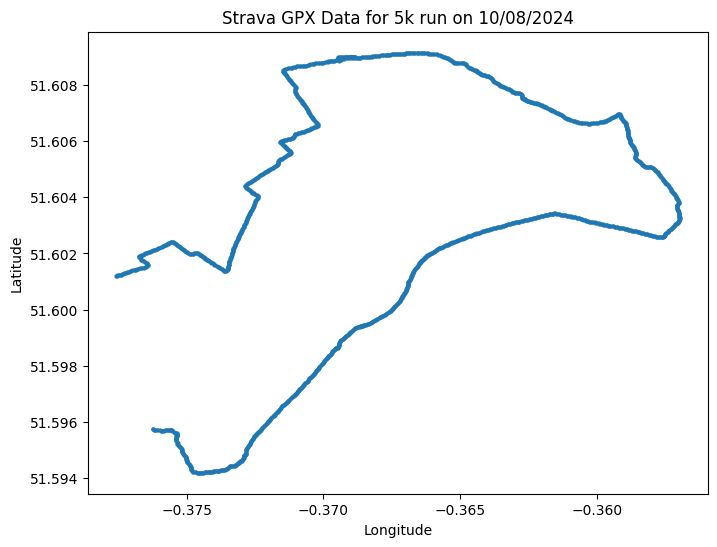

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(df["Longitude"], df["Latitude"], marker="o", linestyle="-", markersize=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Strava GPX Data for 5k run on 10/08/2024")
plt.show()


The following code loops through all the gpx files in the directory - each representing a strava activity - and creates a dataframe for each one. It appends each activity to the meta list. 

In [110]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from geopy.distance import geodesic

# ===== Config =====
gpx_folder = "skye_strava_data/activities"

# ===== Parse GPX files =====
summary_data = []
ns = {"default": "http://www.topografix.com/GPX/1/1"}

for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue
        date = date_tag.text[:10]

        # Get run name
        name_tag = root.find(".//default:name", ns)
        name = name_tag.text if name_tag is not None else filename

        # Extract points
        points = []
        times = []
        for trkpt in root.findall(".//default:trkpt", ns):
            lat = float(trkpt.get("lat"))
            lon = float(trkpt.get("lon"))
            time = trkpt.find("default:time", ns).text
            points.append((lat, lon))
            times.append(pd.to_datetime(time))

        if len(points) < 2:
            continue

        # Calculate distance
        distance = sum(geodesic(points[i-1], points[i]).km for i in range(1, len(points)))

        # Calculate duration (minutes)
        duration = (times[-1] - times[0]).total_seconds() / 60

        # Calculate average pace
        avg_pace = duration / distance if distance > 0 else 0
        pace_str = f"{int(avg_pace)}:{int((avg_pace % 1) * 60):02d}"

        # Add to list
        summary_data.append({
            "Filename": filename,
            "Name": name,
            "Date": date,
            "Distance (km)": round(distance, 2),
            "Duration (min)": round(duration, 1),
            "Avg Pace (min/km)": pace_str
        })

# ===== Save & Show =====
df_summary = pd.DataFrame(summary_data)
print(df_summary)
df_summary.to_csv("all_run_summary.csv", index=False)


           Filename                   Name        Date  Distance (km)  \
0   12111055853.gpx                 2nd 5k  2024-08-10           5.03   
1   12152574009.gpx    sheffield river run  2024-08-15           5.72   
2   12230956645.gpx              a bit wet  2024-08-24           5.02   
3   12238486493.gpx       easy cali warmup  2024-08-25           1.76   
4   12246214233.gpx               with dad  2024-08-26           5.02   
5   12296670661.gpx  bloody boiling ft dad  2024-09-01           6.62   
6   12313259437.gpx   wakehams hill sprint  2024-09-03           0.22   
7   12415303984.gpx        run to climbing  2024-09-15           2.82   
8   12448999123.gpx     uni girls run club  2024-09-19           4.12   
9   12549317388.gpx          Afternoon Run  2024-10-01           5.02   
10  12563420745.gpx              Lunch Run  2024-10-03           1.98   
11  12605893440.gpx       wet run to shops  2024-10-08           1.14   
12  12637471964.gpx  illness can’t stop me  2024-10

The following two plots visualise all of my runs in exeter. The first plot is a simple grayscale plot with adjusted alpha to show the density of runs in certain areas. The second plot employs a same structre of code but uses a different colour map and adds a terrain basemap to make it more readable and visually appealing. 

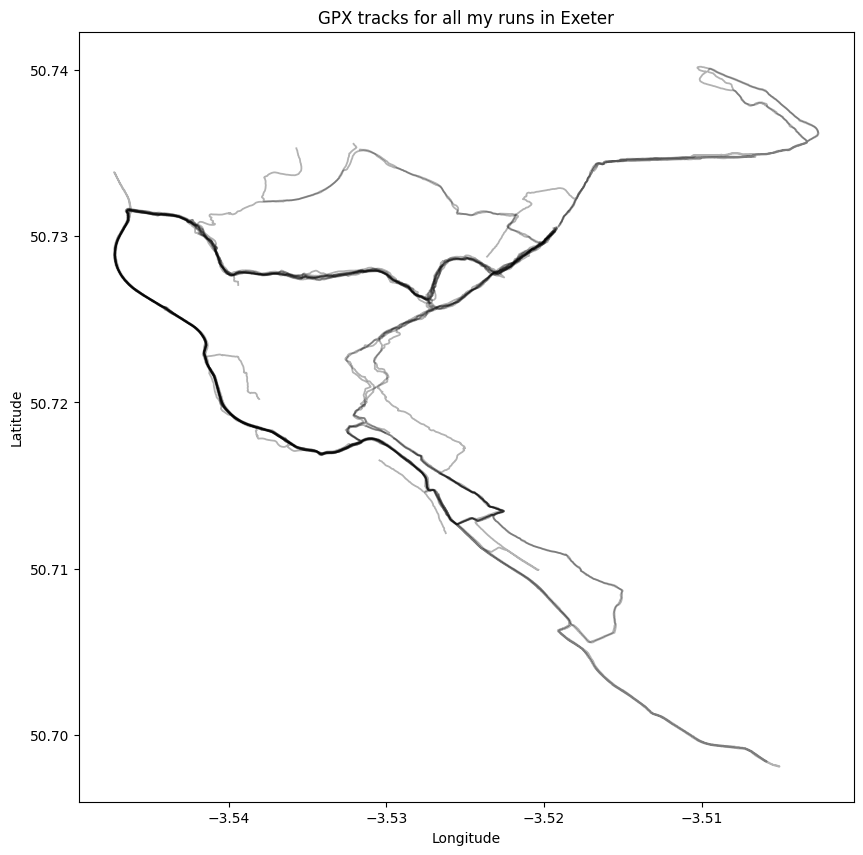

In [143]:

# GPX folder
gpx_folder = "skye_strava_data/activities"

# List of target dates - runs in exeter 
target_dates = [
    "2024-09-09", "2024-09-15", "2024-09-19", "2024-10-01", "2024-10-03", "2024-10-08", "2024-10-12",
    "2024-10-17", "2024-10-22", "2024-11-05", "2024-11-06", "2024-11-14", "2024-11-22", "2024-11-28",
    "2025-01-14", "2025-01-18", "2025-02-18", "2025-02-20", "2025-03-04", "2025-03-05", "2025-03-08",
    "2025-03-18", "2025-03-22", "2025-03-25"
]

# Namespace
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Plot setup
plt.figure(figsize=(10, 10))
plt.title("GPX tracks for all my runs in Exeter")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Loop over files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue  # Skip if no date
        date = date_tag.text[:10]

        if date in target_dates:
            # Extract points
            lats = []
            lons = []
            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.get("lat"))
                lon = float(trkpt.get("lon"))
                lats.append(lat)
                lons.append(lon)

            # Plot
            plt.plot(lons, lats, alpha=0.3, linewidth=1.3, label=date, color="black")

plt.savefig("all_exeter_runs_mapped_grayscale", dpi=300, bbox_inches="tight")

plt.show()


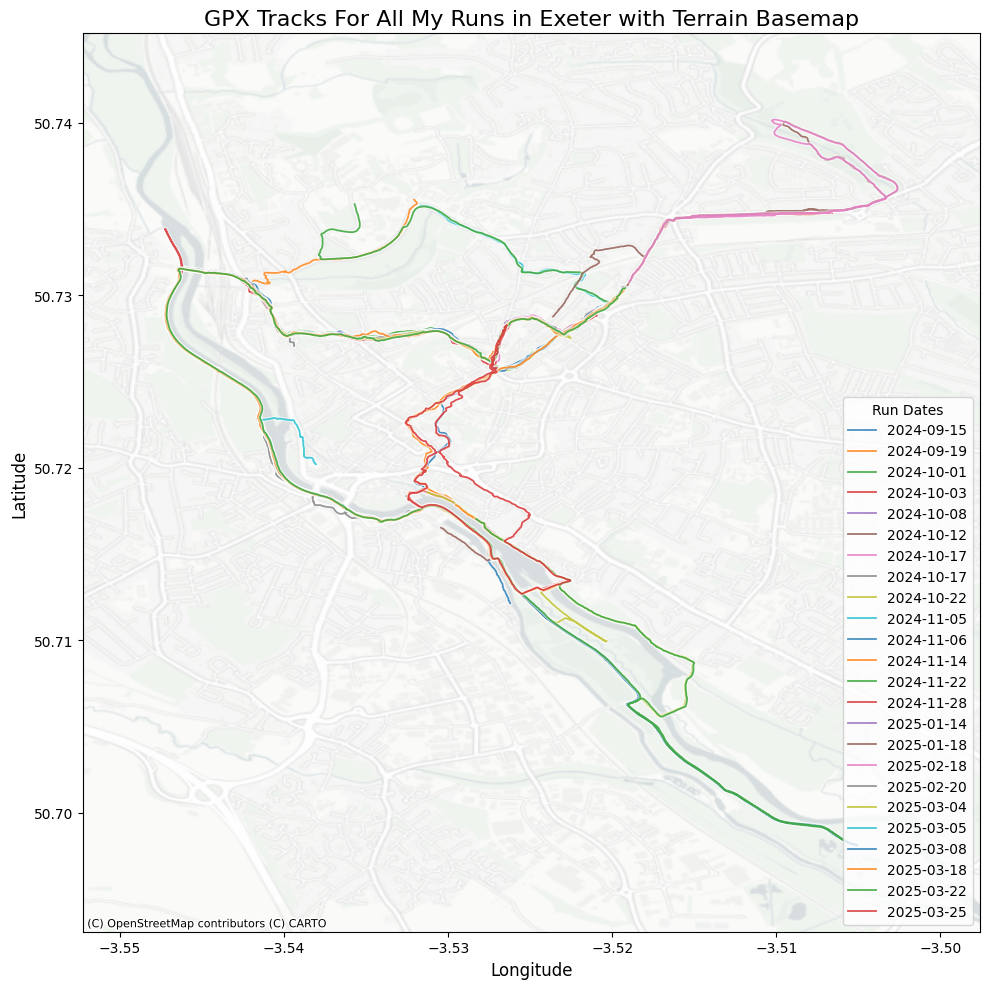

In [142]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import contextily as ctx

# GPX folder
gpx_folder = "skye_strava_data/activities"

# Target dates (Exeter runs)
target_dates = [
    "2024-09-09", "2024-09-15", "2024-09-19", "2024-10-01", "2024-10-03", "2024-10-08", "2024-10-12",
    "2024-10-17", "2024-10-22", "2024-11-05", "2024-11-06", "2024-11-14", "2024-11-22", "2024-11-28",
    "2025-01-14", "2025-01-18", "2025-02-18", "2025-02-20", "2025-03-04", "2025-03-05", "2025-03-08",
    "2025-03-18", "2025-03-22", "2025-03-25"
]

# Namespace
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Store all route coordinates
all_lats = []
all_lons = []

# Set up the plot
plt.figure(figsize=(10, 10))

# Loop over files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue
        date = date_tag.text[:10]

        if date in target_dates:
            lats = []
            lons = []
            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.get("lat"))
                lon = float(trkpt.get("lon"))
                lats.append(lat)
                lons.append(lon)

            # Plot each route with bold colors and outline
            plt.plot(lons, lats, color="white", linewidth=3, alpha=0.5)  # Outline (halo)
            plt.plot(lons, lats, linewidth=1.3, label=date, alpha=0.8)  # Main route

            all_lats.extend(lats)
            all_lons.extend(lons)

# Basemap - Grayscale map
if all_lats and all_lons:
    xmin, xmax = min(all_lons), max(all_lons)
    ymin, ymax = min(all_lats), max(all_lats)

    plt.xlim(xmin - 0.005, xmax + 0.005)  # Add a bit of padding
    plt.ylim(ymin - 0.005, ymax + 0.005)

    ax = plt.gca()
    ctx.add_basemap(
        ax,
        crs="EPSG:4326",
        source=ctx.providers.CartoDB.PositronNoLabels,  # Grayscale map
        alpha=0.9  # Slight transparency to make lines stand out
    )

# Labels and title
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("GPX Tracks For All My Runs in Exeter with Terrain Basemap", fontsize=16)

# Add legend
plt.legend(fontsize=10, loc="lower right", title="Run Dates")

# Adjust layout
plt.tight_layout()

plt.savefig("all_exeter_runs_mapped_colour", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



In [121]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load your processed GPX data
df = pd.read_csv("processed_run_dataTEST.csv")  # Ensure it contains 'Latitude', 'Longitude', 'Speed (m/s)'

# Normalize speed values (avoid extreme values affecting heatmap)
df["Speed (m/s)"] = df["Speed (m/s)"].fillna(0)  # Handle NaNs
df["Speed (m/s)"] = df["Speed (m/s)"] / df["Speed (m/s)"].max()  # Normalize between 0 and 1

# Create a base map centered around the average location
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=15)

# Convert latitude, longitude, and speed into a list of tuples for HeatMap
heat_data = list(zip(df["Latitude"], df["Longitude"], df["Speed (m/s)"]))

# Add heatmap layer where intensity = speed
HeatMap(heat_data, radius=9, blur=8, max_zoom=1).add_to(m)

# Save map as an HTML file and display it
m.save("speed_heatmap.html")
m


C:\Users\leath\AppData\Local\Temp\ipykernel_30852\2103928921.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma_r")  # Reversed plasma: faster = darker, slower = lighter


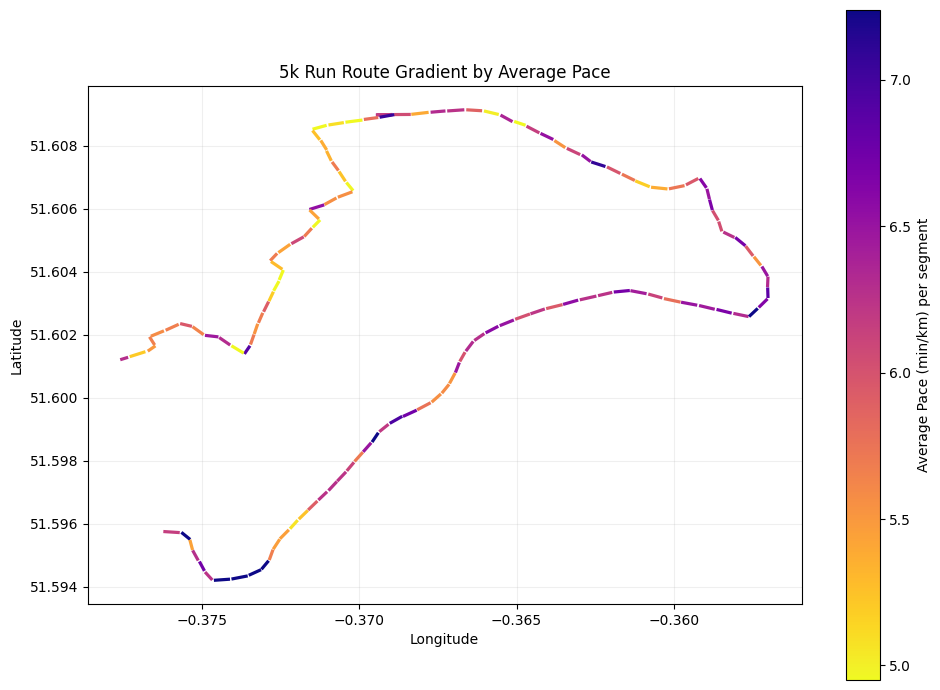

In [144]:
## plotting average pace on a map, use of bins to make segments where average speeds are calculated so it is visually smoother
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# ===== Load Data =====
df = pd.read_csv("processed_run_dataTEST.csv")
df = df.dropna(subset=["Latitude", "Longitude", "Speed (m/s)"])
df = df[df["Speed (m/s)"] > 0]

# ===== Calculate Cumulative Distance =====
distances = [0]
for i in range(1, len(df)):
    prev = (df.iloc[i-1]["Latitude"], df.iloc[i-1]["Longitude"])
    curr = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
    dist = geodesic(prev, curr).meters
    distances.append(dist)
df["Distance (m)"] = distances
df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

# ===== Bin Data =====
bin_size = 40  # meters
df["Bin"] = (df["Cumulative Distance (m)"] // bin_size).astype(int)

# ===== Group into segments =====
segments = []
avg_paces = []

for bin_id, group in df.groupby("Bin"):
    if len(group) < 2:
        continue

    start = (group.iloc[0]["Longitude"], group.iloc[0]["Latitude"])
    end = (group.iloc[-1]["Longitude"], group.iloc[-1]["Latitude"])

    avg_speed = group["Speed (m/s)"].mean()
    avg_pace = (1000 / avg_speed) / 60  # min/km

    segments.append([start, end])
    avg_paces.append(avg_pace)

segments = np.array(segments)

# ===== Normalize paces =====
vmin = np.percentile(avg_paces, 5)
vmax = np.percentile(avg_paces, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = get_cmap("plasma_r")  # Reversed plasma: faster = darker, slower = lighter

# ===== Create Line Collection =====
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.array(avg_paces))
lc.set_linewidth(2.3)

# ===== Plot =====
fig, ax = plt.subplots(figsize=(10, 7))
ax.add_collection(lc)
ax.scatter(df["Longitude"], df["Latitude"], color="white", s=1, alpha=0.7)

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label("Average Pace (min/km) per segment")

ax.set_title("5k Run Route Gradient by Average Pace")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


C:\Users\leath\AppData\Local\Temp\ipykernel_30852\1851973315.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma_r")


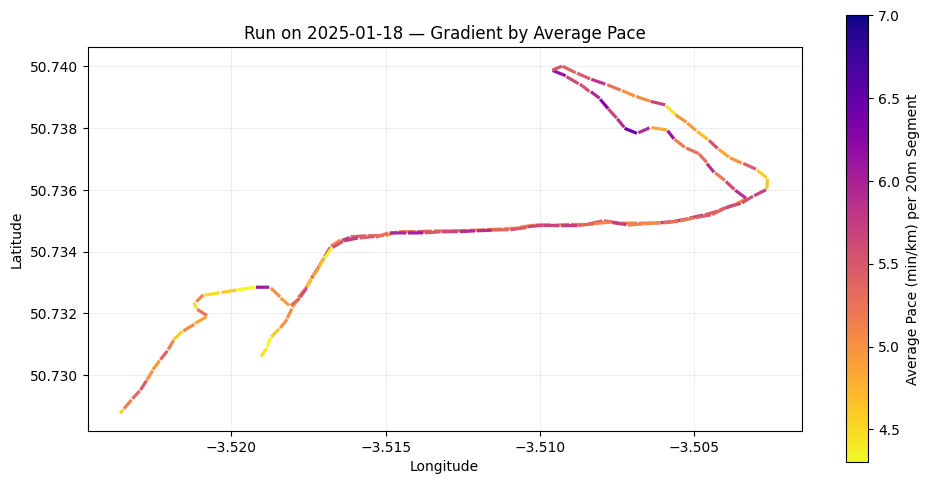

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
import os

# process GPX data
def gpx_to_dataframe(gpx_path):
    ns = {"default": "http://www.topografix.com/GPX/1/1"}
    tree = ET.parse(gpx_path)
    root = tree.getroot()

    data = []
    for trkpt in root.findall(".//default:trkpt", ns):
        lat = float(trkpt.get("lat"))
        lon = float(trkpt.get("lon"))
        ele = float(trkpt.find("default:ele", ns).text)
        time = trkpt.find("default:time", ns).text
        data.append((lat, lon, ele, time))

    df = pd.DataFrame(data, columns=["Latitude", "Longitude", "Elevation", "Time"])
    df["Time"] = pd.to_datetime(df["Time"])

    # Calculate distance
    distances = [0]
    for i in range(1, len(df)):
        prev = (df.iloc[i-1]["Latitude"], df.iloc[i-1]["Longitude"])
        curr = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
        dist = geodesic(prev, curr).meters
        distances.append(dist)
    df["Distance (m)"] = distances
    df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

    # Time difference
    df["Time Diff (s)"] = df["Time"].diff().dt.total_seconds().fillna(0)
    df["Speed (m/s)"] = df["Distance (m)"] / df["Time Diff (s)"]
    df = df.dropna(subset=["Latitude", "Longitude", "Speed (m/s)"])
    df = df[df["Speed (m/s)"] > 0]
    return df

# ===== Original Data =====
df_ref = pd.read_csv("processed_run_dataTEST.csv")
df_ref = df_ref.dropna(subset=["Latitude", "Longitude", "Speed (m/s)"])
df_ref = df_ref[df_ref["Speed (m/s)"] > 0]

# ===== Get global vmin/vmax =====
ref_paces = (1000 / df_ref["Speed (m/s)"]) / 60  # min/km
vmin = 4.3  # min/km
vmax = 7.0  # min/km

# ===== Load new run =====
gpx_path = "skye_strava_data/activities/13388748661.gpx"  
df = gpx_to_dataframe(gpx_path)

# ===== Bin Data =====
bin_size = 40  # meters
df["Bin"] = (df["Cumulative Distance (m)"] // bin_size).astype(int)

# ===== Group into segments =====
segments = []
avg_paces = []

for bin_id, group in df.groupby("Bin"):
    if len(group) < 2:
        continue

    start = (group.iloc[0]["Longitude"], group.iloc[0]["Latitude"])
    end = (group.iloc[-1]["Longitude"], group.iloc[-1]["Latitude"])

    avg_speed = group["Speed (m/s)"].mean()
    avg_pace = (1000 / avg_speed) / 60  # min/km

    segments.append([start, end])
    avg_paces.append(avg_pace)

segments = np.array(segments)

# ===== Normalize and Plot =====
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = get_cmap("plasma_r")

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.array(avg_paces))
lc.set_linewidth(2.3)

fig, ax = plt.subplots(figsize=(10, 5))
ax.add_collection(lc)
ax.scatter(df["Longitude"], df["Latitude"], color="white", s=1, alpha=0.7)

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label("Average Pace (min/km) per 20m Segment")

ax.set_title("Run on 2025-01-18 — Gradient by Average Pace")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()




In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load your processed GPX data
df = pd.read_csv("processed_run_dataTEST.csv")  # Ensure it contains 'Latitude', 'Longitude', 'Speed (m/s)'

# Normalize speed values (avoid extreme values affecting heatmap)
df["Speed (m/s)"] = df["Speed (m/s)"].fillna(0)  # Handle NaNs
df["Speed (m/s)"] = df["Speed (m/s)"] / df["Speed (m/s)"].max()  # Normalize between 0 and 1

# Create a base map centered around the average location
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=15)

# Convert latitude, longitude, and speed into a list of tuples for HeatMap
heat_data = list(zip(df["Latitude"], df["Longitude"], df["Speed (m/s)"]))

# Add heatmap layer where intensity = speed
HeatMap(heat_data, radius=9, blur=8, max_zoom=1).add_to(m)

# Save map as an HTML file and display it
m.save("speed_heatmap.html")
m


C:\Users\leath\AppData\Local\Temp\ipykernel_30852\1971589168.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma_r")  # Reversed plasma: faster = darker, slower = lighter


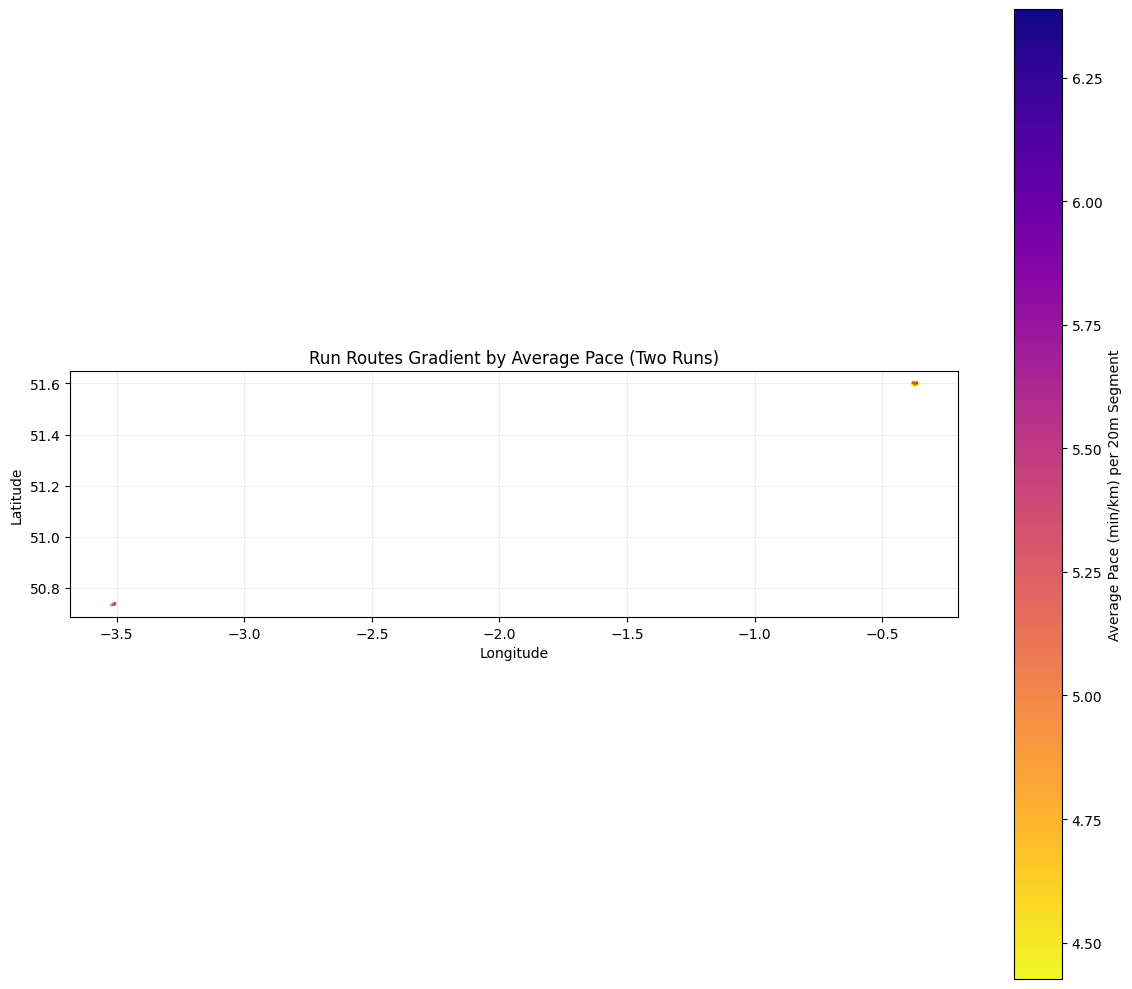

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
import xml.etree.ElementTree as ET

# ===== Load and Process GPX =====
def gpx_to_dataframe(gpx_path):
    ns = {"default": "http://www.topografix.com/GPX/1/1"}
    tree = ET.parse(gpx_path)
    root = tree.getroot()

    data = []
    for trkpt in root.findall(".//default:trkpt", ns):
        lat = float(trkpt.get("lat"))
        lon = float(trkpt.get("lon"))
        ele = float(trkpt.find("default:ele", ns).text)
        time = trkpt.find("default:time", ns).text
        data.append((lat, lon, ele, time))

    df = pd.DataFrame(data, columns=["Latitude", "Longitude", "Elevation", "Time"])
    df["Time"] = pd.to_datetime(df["Time"])

    # Calculate distance
    distances = [0]
    for i in range(1, len(df)):
        prev = (df.iloc[i-1]["Latitude"], df.iloc[i-1]["Longitude"])
        curr = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
        dist = geodesic(prev, curr).meters
        distances.append(dist)
    df["Distance (m)"] = distances
    df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

    # Time difference
    df["Time Diff (s)"] = df["Time"].diff().dt.total_seconds().fillna(0)
    df["Speed (m/s)"] = df["Distance (m)"] / df["Time Diff (s)"]
    df = df.dropna(subset=["Latitude", "Longitude", "Speed (m/s)"])
    df = df[df["Speed (m/s)"] > 0]
    return df

# ===== Process the First GPX File (existing data) =====
gpx_path_1 = "skye_strava_data/activities/13388748661.gpx"  # Adjust path if needed
df_1 = gpx_to_dataframe(gpx_path_1)

# ===== Process the Second GPX File =====
gpx_path_2 = "skye_strava_data/activities/13128292001.gpx"  # Adjust path if needed
df_2 = gpx_to_dataframe(gpx_path_2)

# ===== Calculate Paces and Create Segments for Both Runs =====
def create_segments(df):
    # Bin the data
    bin_size = 20  # meters
    df["Bin"] = (df["Cumulative Distance (m)"] // bin_size).astype(int)

    segments = []
    avg_paces = []

    for bin_id, group in df.groupby("Bin"):
        if len(group) < 2:
            continue

        start = (group.iloc[0]["Longitude"], group.iloc[0]["Latitude"])
        end = (group.iloc[-1]["Longitude"], group.iloc[-1]["Latitude"])

        avg_speed = group["Speed (m/s)"].mean()
        avg_pace = (1000 / avg_speed) / 60  # min/km

        segments.append([start, end])
        avg_paces.append(avg_pace)

    return np.array(segments), np.array(avg_paces)

# Create segments for both runs
segments_1, avg_paces_1 = create_segments(df_1)
segments_2, avg_paces_2 = create_segments(df_2)

# ===== Get Global vmin/vmax Based on Both Runs =====
all_paces = np.concatenate([avg_paces_1, avg_paces_2])
vmin = np.percentile(all_paces, 5)
vmax = np.percentile(all_paces, 95)

# ===== Plotting =====
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the first run
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = get_cmap("plasma_r")  # Reversed plasma: faster = darker, slower = lighter
lc_1 = LineCollection(segments_1, cmap=cmap, norm=norm)
lc_1.set_array(avg_paces_1)
lc_1.set_linewidth(2)
ax.add_collection(lc_1)

# Plot the second run
lc_2 = LineCollection(segments_2, cmap=cmap, norm=norm)
lc_2.set_array(avg_paces_2)
lc_2.set_linewidth(2)
ax.add_collection(lc_2)

# Add scatter points for both runs
ax.scatter(df_1["Longitude"], df_1["Latitude"], color="white", s=1, alpha=0.5)
ax.scatter(df_2["Longitude"], df_2["Latitude"], color="yellow", s=1, alpha=0.5)

# Add color bar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label("Average Pace (min/km) per 20m Segment")

# Title and labels
ax.set_title("Run Routes Gradient by Average Pace (Two Runs)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

